In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sb
import torch
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))


In [2]:
# get the data
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
print(train.shape, test.shape)

(42000, 785) (28000, 784)


In [3]:
# divide train into X_train and y_train
X_train = train.drop("label",axis=1)
X_test = test
y_train = np.array(train['label'])
X_train.shape, y_train.shape


((42000, 784), (42000,))

In [4]:
# reshape
X_train = X_train.values.reshape(-1,28,28)
X_test = X_test.values.reshape(-1,28,28)
print(X_train.shape, X_test.shape)

(42000, 28, 28) (28000, 28, 28)


In [5]:
# divide into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=2)

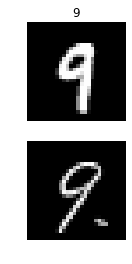

In [6]:
# look at random samples
i = 2
#print(y_train[i])
plt.subplot(2,1,1)
plt.imshow(X_train[i,:,:], cmap='gray')
plt.title(y_train[i])
plt.axis('off')

plt.subplot(2,1,2)
plt.imshow(X_test[i,:,:], cmap='gray')
plt.axis('off')

plt.show()

# double image: 1 from train and 1 from test

In [7]:
# probably should normalize or smth, not sure though

In [8]:
# convert numpy arrays to torch tensors
X_train = torch.from_numpy(X_train).float()
X_train.requires_grad = True
X_train = X_train.view(X_train.size()[0], -1)

X_test = torch.from_numpy(X_test).float()
X_test = X_test.view(X_test.size()[0], -1)

X_val = torch.from_numpy(X_val).float()
X_val = X_val.view(X_val.size()[0], -1)

y_train = torch.from_numpy(y_train).long()
y_val = torch.from_numpy(y_val).long()

In [9]:
# make a model
class FCNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(FCNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x
    
mnist_net = FCNet(100)

In [10]:
# move to device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)

In [11]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

In [12]:
# train a model + append error

batch_size = 2100

train_accuracy_history = []
val_accuracy_history = []

for epoch in range(1,41):
    order = np.random.permutation(len(X_train))
    
    for _, start_index in enumerate(tqdm(range(0, len(X_train), batch_size))):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    train_preds = torch.tensor([])
    for start_index in range(0, len(X_train), batch_size):
        batch_indexes = range(start_index,start_index+batch_size)
        X_train_batch = X_train[batch_indexes].to(device)
        train_preds = torch.cat((train_preds, mnist_net.forward(X_train_batch).cpu()),0)
        
    val_preds = torch.tensor([])
    for start_index in range(0, len(X_val), batch_size):
        batch_indexes = range(start_index,start_index+batch_size)
        X_val_batch =  X_val[batch_indexes].to(device)
        val_preds = torch.cat((val_preds, mnist_net.forward(X_val_batch).cpu()),0)
    
    #test_loss_history.append(loss(test_preds, y_test))
    
    train_accuracy = (train_preds.argmax(dim=1) == y_train).float().mean()
    val_accuracy = (val_preds.argmax(dim=1) == y_val).float().mean()
    
    train_accuracy_history.append(train_accuracy)
    val_accuracy_history.append(val_accuracy)
    
    print('Epoch',epoch)
    print('Accuracy: train', round(train_accuracy.item(),5), 'validation', round(val_accuracy.item(),5))


  6%|▌         | 1/18 [00:00<00:01,  8.68it/s]

Epoch 1
Accuracy: train 0.84495 validation 0.84381


  6%|▌         | 1/18 [00:00<00:01,  9.30it/s]

Epoch 2
Accuracy: train 0.8886 validation 0.88071


  6%|▌         | 1/18 [00:00<00:01,  9.49it/s]

Epoch 3
Accuracy: train 0.90444 validation 0.89429


  6%|▌         | 1/18 [00:00<00:01,  9.53it/s]

Epoch 4
Accuracy: train 0.91974 validation 0.90857


  6%|▌         | 1/18 [00:00<00:01,  9.98it/s]

Epoch 5
Accuracy: train 0.93307 validation 0.92048


  6%|▌         | 1/18 [00:00<00:02,  8.50it/s]

Epoch 6
Accuracy: train 0.94188 validation 0.9231


  6%|▌         | 1/18 [00:00<00:01,  8.97it/s]

Epoch 7
Accuracy: train 0.94944 validation 0.92452


  6%|▌         | 1/18 [00:00<00:01,  8.84it/s]

Epoch 8
Accuracy: train 0.95521 validation 0.93286


  6%|▌         | 1/18 [00:00<00:01,  8.56it/s]

Epoch 9
Accuracy: train 0.96093 validation 0.93429


  6%|▌         | 1/18 [00:00<00:01,  9.50it/s]

Epoch 10
Accuracy: train 0.96365 validation 0.93405


  6%|▌         | 1/18 [00:00<00:01,  9.68it/s]

Epoch 11
Accuracy: train 0.96817 validation 0.93881


  6%|▌         | 1/18 [00:00<00:01,  9.20it/s]

Epoch 12
Accuracy: train 0.96981 validation 0.94


  6%|▌         | 1/18 [00:00<00:01,  9.49it/s]

Epoch 13
Accuracy: train 0.97362 validation 0.94


  6%|▌         | 1/18 [00:00<00:01,  9.31it/s]

Epoch 14
Accuracy: train 0.97672 validation 0.94476


  6%|▌         | 1/18 [00:00<00:01,  9.51it/s]

Epoch 15
Accuracy: train 0.97923 validation 0.94405


  6%|▌         | 1/18 [00:00<00:01,  9.80it/s]

Epoch 16
Accuracy: train 0.98061 validation 0.94619


  6%|▌         | 1/18 [00:00<00:01,  9.47it/s]

Epoch 17
Accuracy: train 0.98212 validation 0.945


  6%|▌         | 1/18 [00:00<00:01,  9.91it/s]

Epoch 18
Accuracy: train 0.98431 validation 0.94571


  6%|▌         | 1/18 [00:00<00:01,  9.89it/s]

Epoch 19
Accuracy: train 0.98487 validation 0.94619


  6%|▌         | 1/18 [00:00<00:01,  9.78it/s]

Epoch 20
Accuracy: train 0.98791 validation 0.94881


  6%|▌         | 1/18 [00:00<00:01,  9.18it/s]

Epoch 21
Accuracy: train 0.98902 validation 0.94833


  6%|▌         | 1/18 [00:00<00:01,  9.39it/s]

Epoch 22
Accuracy: train 0.99026 validation 0.95


  6%|▌         | 1/18 [00:00<00:01,  9.64it/s]

Epoch 23
Accuracy: train 0.99132 validation 0.95


  6%|▌         | 1/18 [00:00<00:01,  9.70it/s]

Epoch 24
Accuracy: train 0.99143 validation 0.95


  6%|▌         | 1/18 [00:00<00:01,  9.35it/s]

Epoch 25
Accuracy: train 0.99304 validation 0.95167


  6%|▌         | 1/18 [00:00<00:01,  8.67it/s]

Epoch 26
Accuracy: train 0.99315 validation 0.95095


  6%|▌         | 1/18 [00:00<00:01,  8.78it/s]

Epoch 27
Accuracy: train 0.99378 validation 0.95167


  6%|▌         | 1/18 [00:00<00:01,  9.94it/s]

Epoch 28
Accuracy: train 0.99463 validation 0.95214


  6%|▌         | 1/18 [00:00<00:01,  9.77it/s]

Epoch 29
Accuracy: train 0.99503 validation 0.95262


  6%|▌         | 1/18 [00:00<00:01,  9.74it/s]

Epoch 30
Accuracy: train 0.99585 validation 0.95095


  6%|▌         | 1/18 [00:00<00:01,  8.93it/s]

Epoch 31
Accuracy: train 0.99659 validation 0.9531


  6%|▌         | 1/18 [00:00<00:01,  9.80it/s]

Epoch 32
Accuracy: train 0.99683 validation 0.95095


  6%|▌         | 1/18 [00:00<00:01,  9.70it/s]

Epoch 33
Accuracy: train 0.99735 validation 0.9519


  6%|▌         | 1/18 [00:00<00:01,  9.27it/s]

Epoch 34
Accuracy: train 0.99762 validation 0.95286


  6%|▌         | 1/18 [00:00<00:01,  9.27it/s]

Epoch 35
Accuracy: train 0.99775 validation 0.95333


  6%|▌         | 1/18 [00:00<00:01,  9.55it/s]

Epoch 36
Accuracy: train 0.99802 validation 0.95262


  6%|▌         | 1/18 [00:00<00:01,  9.05it/s]

Epoch 37
Accuracy: train 0.99847 validation 0.95357


  6%|▌         | 1/18 [00:00<00:01,  8.81it/s]

Epoch 38
Accuracy: train 0.99857 validation 0.9519


  6%|▌         | 1/18 [00:00<00:01,  9.28it/s]

Epoch 39
Accuracy: train 0.99865 validation 0.95452


100%|██████████| 18/18 [00:01<00:00,  9.22it/s]


Epoch 40
Accuracy: train 0.99886 validation 0.95381


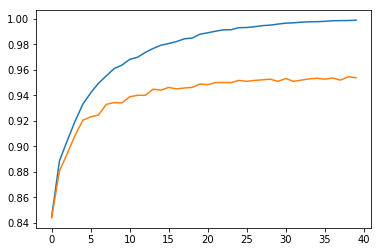

In [13]:
# show graph of train and validation error over epoch
plt.plot(train_accuracy_history)
plt.plot(val_accuracy_history)

In [14]:
test_pred = mnist_net.forward(X_test).argmax(dim=1)
test_pred = pd.Series(test_pred, name='Label')
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),test_pred],axis = 1)
submission.to_csv("mnist_fcnn.csv",index=False)

In [15]:
# use gpu
# find a model that does atleast 99.5